In [1]:
from matplotlib import pyplot as plt
import os
import cv2 #import OpenCV

def show_image_mask_mask(img, mask,out, cmap='gray'): # function shows image and 2 masks 
    fig = plt.figure(figsize=(5,5))
    plt.subplot(1, 3, 1,label='image')
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    
    plt.subplot(1, 3, 2,label='mask')
    plt.imshow(mask, cmap=cmap)
    plt.axis('off')
    plt.subplot(1, 3, 3,label='predicted mask')
    plt.imshow(out, cmap=cmap)
    plt.axis('off')

def show_image_mask(img, mask, cmap='gray'): # known function that shows an image and a mask
    fig = plt.figure(figsize=(5,5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap=cmap)
    plt.axis('off')


data_dir = './data/train'
image = cv2.imread(os.path.join(data_dir,'image','cmr1.png'), cv2.IMREAD_UNCHANGED)
mask = cv2.imread(os.path.join(data_dir,'mask','cmr1_mask.png'), cv2.IMREAD_UNCHANGED)
#print(image.shape,mask.shape)
#show_image_mask(image, mask, cmap='gray')
# i=cv2.imread("E:/zip/cardiac-img-seg-main/cardiac-img-seg-main/data/test/mask/cmr1556_mask.png")
# show_image_mask(image, i, cmap='gray')
# plt.imshow(i)
plt.pause(1)
cv2.imwrite(os.path.join('./','cmr1.png'), mask*85)


True

In [2]:
from torch.utils.data import DataLoader
import torch,numpy as np
import torch.utils.data as data
import cv2
import os
from glob import glob
import albumentations as A

transform = A.Compose([
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5,border_mode=1),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
    
])

class TrainDataset(data.Dataset):
    def __init__(self, root=''):
        super(TrainDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))
        self.mask_files = []
        for img_path in self.img_files:
            basename = os.path.basename(img_path)
            self.mask_files.append(os.path.join(root,'mask',basename[:-4]+'_mask.png'))
            

    def __getitem__(self, index):
            global transform
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            label = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            transformed =  transform(image=data,mask=label)
            return torch.from_numpy(np.expand_dims(transformed['image'],axis=0)).float(), torch.from_numpy(transformed['mask']).float()

    def __len__(self):
        return len(self.img_files)
    
    
class ValDataset(data.Dataset):
    def __init__(self, root=''):
        super(ValDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))
        self.mask_files = []
        for img_path in self.img_files:
            basename = os.path.basename(img_path)
            self.mask_files.append(os.path.join(root,'mask',basename[:-4]+'_mask.png'))
            

    def __getitem__(self, index):
            global transform
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            label = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            
            return torch.from_numpy(np.expand_dims(data,axis=0)).float(), torch.from_numpy(label).float()

    def __len__(self):
        return len(self.img_files)
    
class TestDataset(data.Dataset):
    def __init__(self, root=''):
        super(TestDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))

    def __getitem__(self, index):
            img_path = self.img_files[index]
            data = np.expand_dims(cv2.imread(img_path, cv2.IMREAD_UNCHANGED), axis=0)
            return torch.from_numpy(data).float() , img_path

    def __len__(self):
        return len(self.img_files)

In [3]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="efficientnet-b4",       
    encoder_weights="imagenet",     
    in_channels=1,                  
    classes=4,                      
)

This next cell contains the main training loop. The loss fucntion used is also taken from the smp library where the model comes from. The loss function is a log-based multiclass dice loss. It gives better training performance as compared to the vanilla CrossEntropy loss of nn module, which stagnates after a point. We use the Adam optimizer.

In [4]:
import time
import segmentation_models_pytorch as smp

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"The current device is {device}")

#model=torch.load('u-effb4_100.pth')
model.to(device)

epochs = 1  #50
data_path = './data/train'
num_workers = 0
batch_size = 5
train_set = TrainDataset(data_path)
training_data_loader = DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)

loss_fn = torch.nn.CrossEntropyLoss()
loss_fn_2 = smp.losses.DiceLoss('multiclass', classes=None, log_loss=True, from_logits=True, smooth=0.0, ignore_index=None, eps=1e-07)
train_loss=[]

model.train()
#opt_sgd = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
opt = torch.optim.Adam(model.parameters(), lr=0.0008)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min')

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for image,mask in training_data_loader:
        #print(image.shape,mask.shape)
        image.to(device)
        mask.to(device)
        image = image.to(device)
        mask = mask.to(device)
        
        out = model(image)
        loss = loss_fn_2(out,mask.long())
        opt.zero_grad()
        loss.backward()
        opt.step()

        # print statistics - epoch and loss
        running_loss += loss.item()
        print(loss.item())
        
        
    train_loss.append(running_loss)
    print(running_loss,' - loss for epoch: ',epoch)
    time.sleep(10)
    if epoch%10 == 0:
        torch.save(model,'u-effb4_chckpnt.pth')
    
        
print('Finished Training')
torch.save(model,'u-effb4_100.pth')

The current device is cpu
3.053800582885742
3.0184826850891113
2.6401548385620117
2.841930866241455
3.1547014713287354
2.6895861625671387
2.734112024307251
2.680229902267456
2.959066152572632
2.8531124591827393
2.8054563999176025
2.729764461517334
2.659895181655884
2.4321227073669434
2.6748924255371094
2.3134796619415283
2.962367534637451
2.9655418395996094
2.3407719135284424
2.1029086112976074
2.217507839202881
2.5514075756073
2.8210411071777344
1.907873272895813
2.142273426055908
2.669732093811035
2.494863748550415
2.3678672313690186
2.0279948711395264
1.9562633037567139
2.3079886436462402
1.8571816682815552
1.7632423639297485
1.958827257156372
1.9196265935897827
1.8215152025222778
1.74752676486969
2.1926236152648926
1.6005066633224487
1.4657082557678223
2.2126235961914062
1.919562578201294
1.9977484941482544
1.5682085752487183
2.0192484855651855
1.7603816986083984
2.2069170475006104
1.5973379611968994
1.8030731678009033
1.927681803703308
1.7836346626281738
1.4400570392608643
1.81581

The next cells define the evaluation loss used for scoring the model. We then have the valuation and test loops based on this scoring metric, and the helper code for submission

In [5]:
def categorical_dice(mask1, mask2, label_class=1):
    """
    Dice score of a specified class between two volumes of label masks.
    (classes are encoded but by label class number not one-hot )
    Note: stacks of 2D slices are considered volumes.

    Args:
        mask1: N label masks, numpy array shaped (H, W, N)
        mask2: N label masks, numpy array shaped (H, W, N)
        label_class: the class over which to calculate dice scores

    Returns:
        volume_dice
    """
    mask1_pos = (mask1 == label_class).astype(np.float32)
    mask2_pos = (mask2 == label_class).astype(np.float32)
    dice = 2 * np.sum(mask1_pos * mask2_pos) / (np.sum(mask1_pos) + np.sum(mask2_pos))
    return dice

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"The current device is {device}")
#model=torch.load('u-effb4_100.pth')
#model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()

num_workers = 0
batch_size = 5
data_path='./data/val'
val_set = ValDataset(data_path)
training_data_loader = DataLoader(dataset=val_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)

model.eval()
total_val_score=0
for image,mask in training_data_loader:
        #print(image.shape,mask.shape)
        image = image.to(device)
        mask = mask.to(device)
        out = model(image)
        loss = loss_fn(out,mask.long())
        print('CE loss score for image : ',loss.item())
        
        out_np = torch.max(out,1).indices.cpu().detach().numpy()                  # converts to numpy for calculations
        mask_np = mask.cpu().detach().numpy()
        image_np = image.cpu().detach().numpy()
        #print(out_np[0].shape,mask_np.shape)
        d_score=0
        for j in range(1,4):
            d_score += categorical_dice(mask_np[0], out_np[0],j)
        print("d_loss for class ",j," : ",d_score/3 )
        total_val_score += d_score/3
        for i in range(1):
            #show_image_mask_mask(image_np[i,0],mask_np[i], out_np[i], cmap='gray')
            plt.pause(1)
print("Val_score : ",total_val_score/20)
        

The current device is cpu
CE loss score for image :  0.5999096632003784
d_loss for class  3  :  0.0
CE loss score for image :  0.4016946852207184
d_loss for class  3  :  0.0
CE loss score for image :  0.7312538623809814
d_loss for class  3  :  0.2462081073426731
CE loss score for image :  0.817839503288269
d_loss for class  3  :  0.05111624326404927
Val_score :  0.014866217530336118


In [7]:
'''import matplotlib.pyplot as plt
import numpy as np

def save_image_mask_side_by_side(image, mask, save_path, cmap='gray'):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Display the input image on the left side
    ax[0].imshow(image, cmap=cmap)
    ax[0].axis('off')
    ax[0].set_title('Input Image')

    # Display the predicted mask on the right side
    ax[1].imshow(mask, cmap=cmap)
    ax[1].axis('off')
    ax[1].set_title('Predicted Mask')
    plt.savefig(save_path)
    plt.close()'''

C:\Users\vinay\AppData\Local\Temp\ipykernel_6192\1972682241.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(5,5))


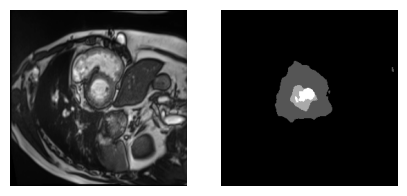

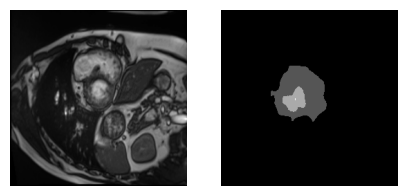

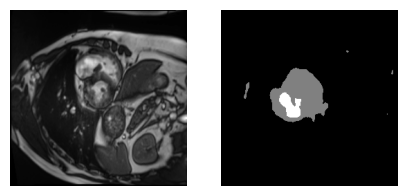

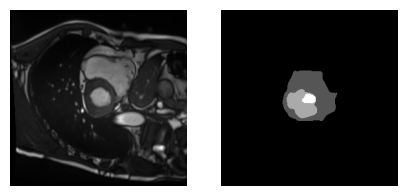

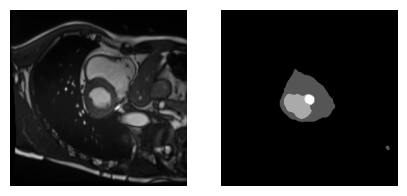

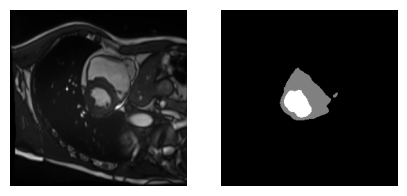

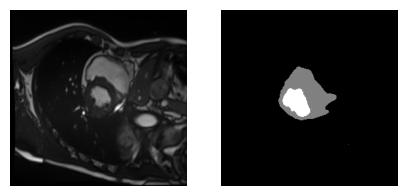

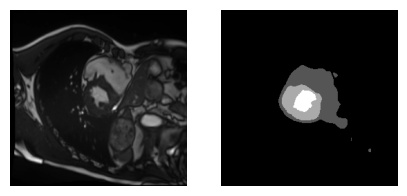

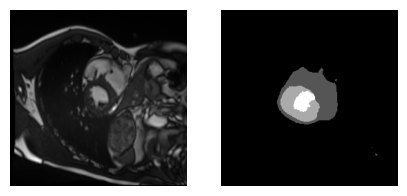

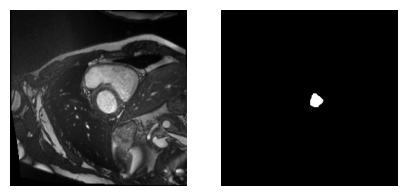

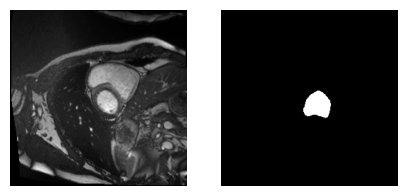

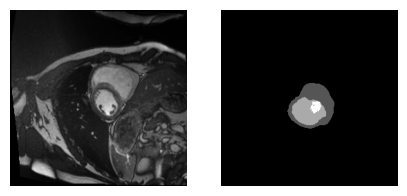

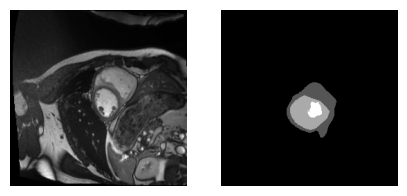

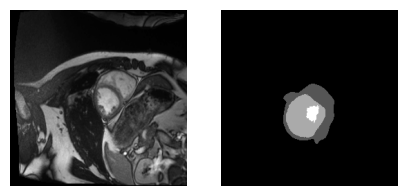

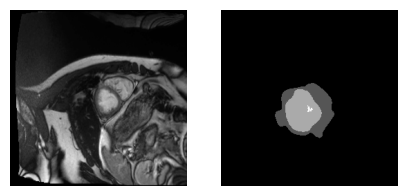

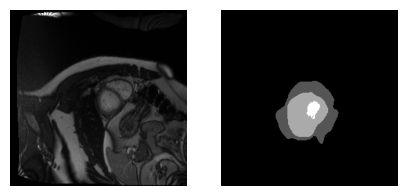

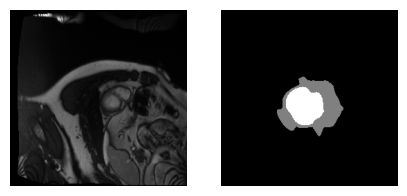

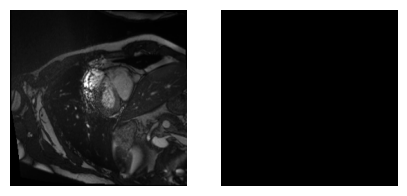

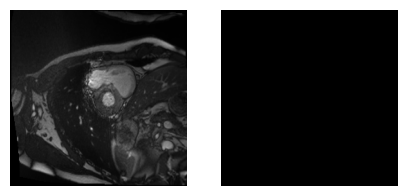

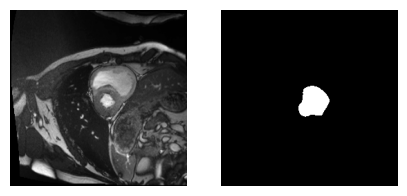

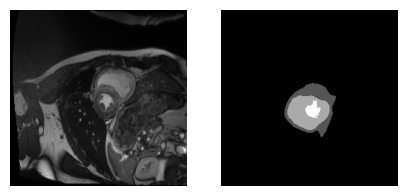

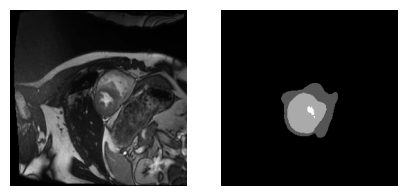

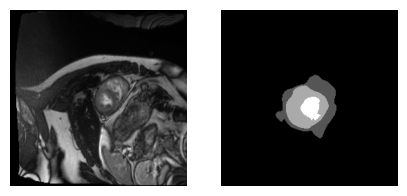

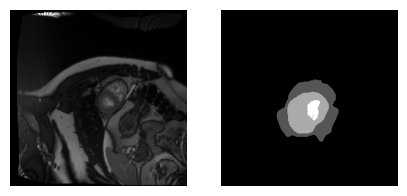

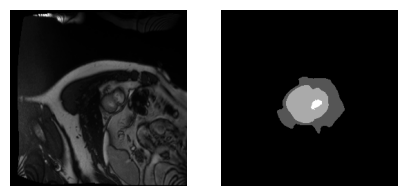

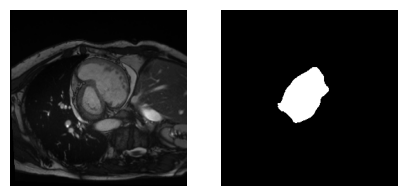

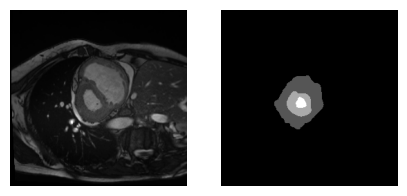

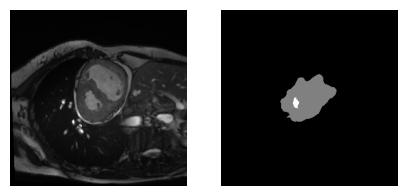

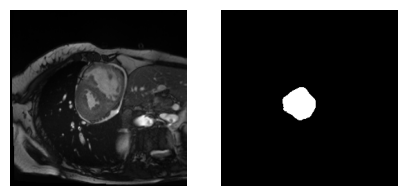

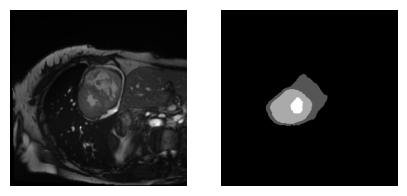

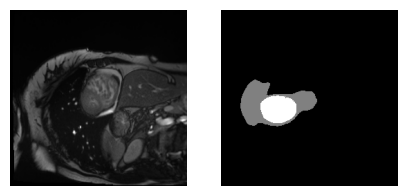

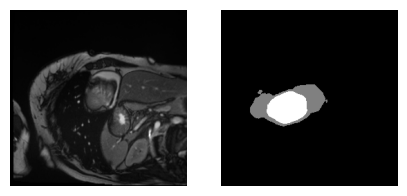

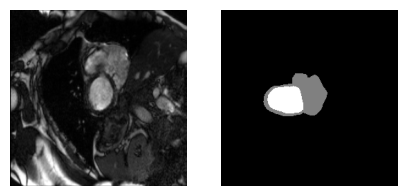

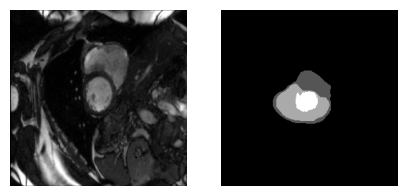

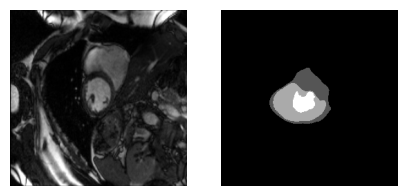

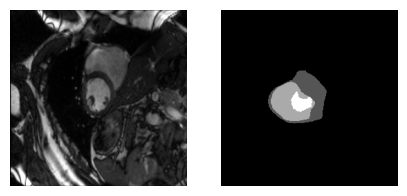

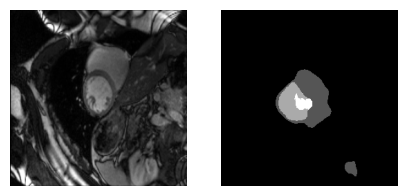

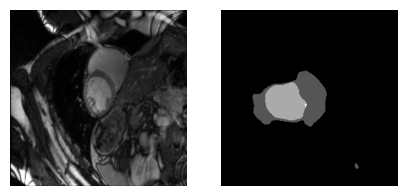

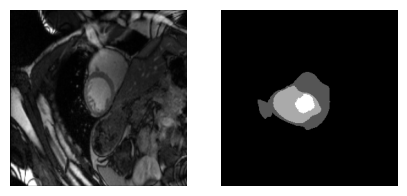

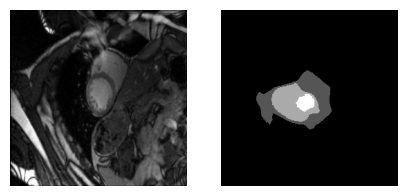

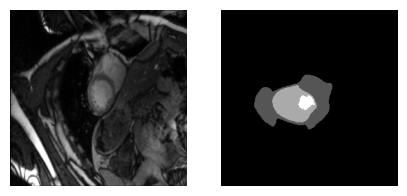

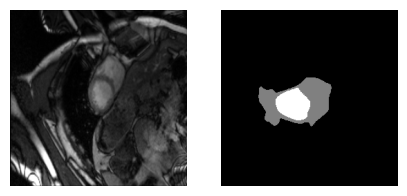

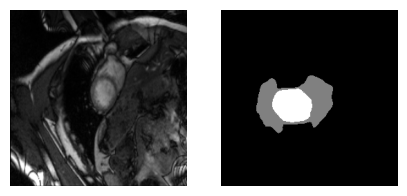

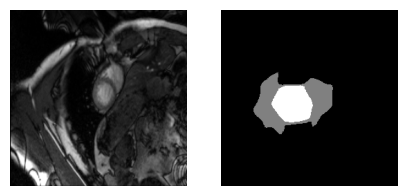

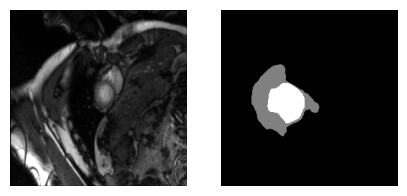

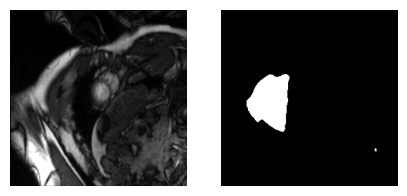

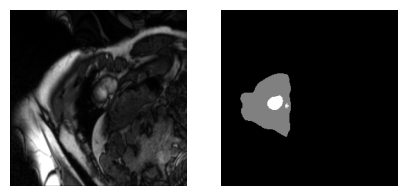

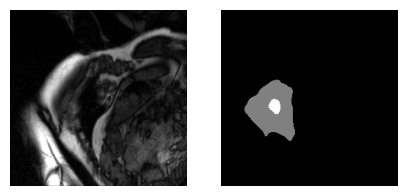

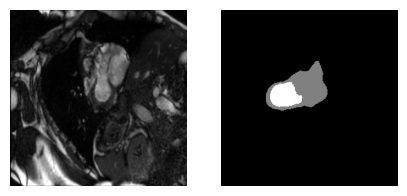

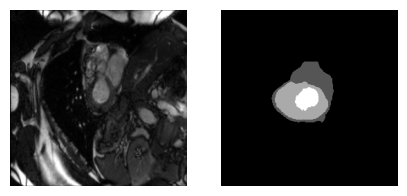

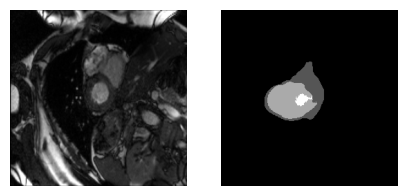

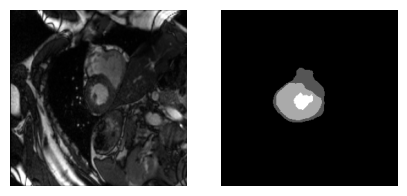

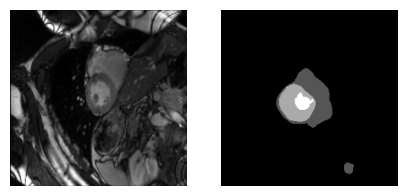

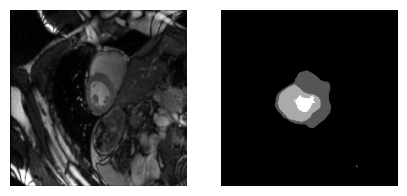

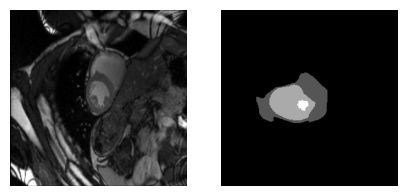

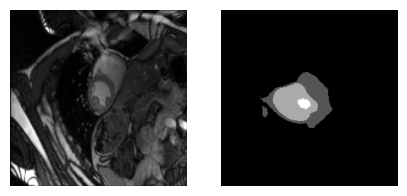

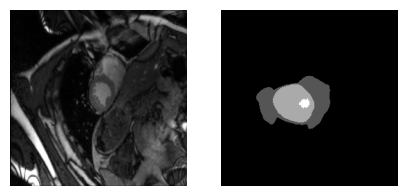

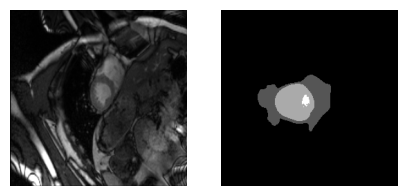

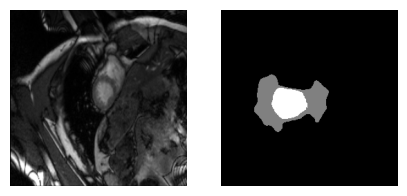

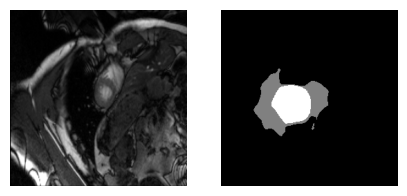

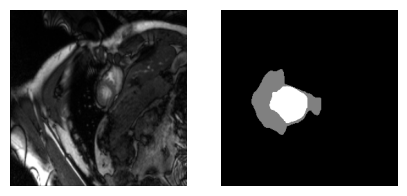

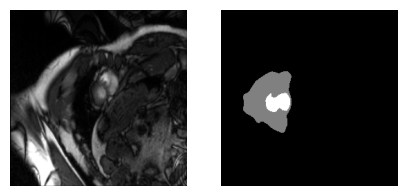

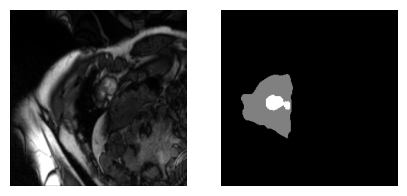

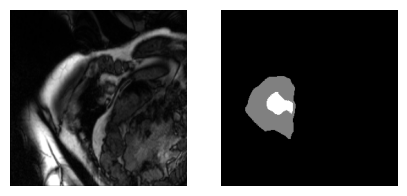

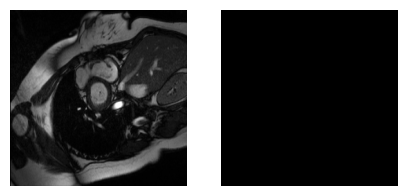

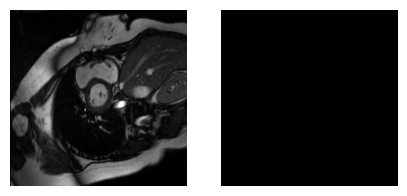

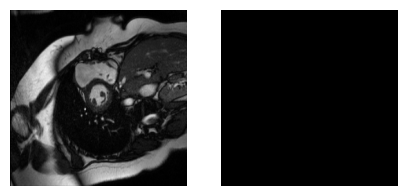

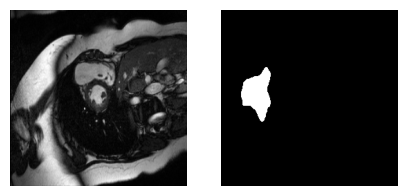

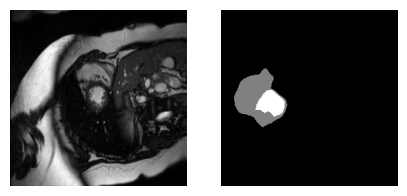

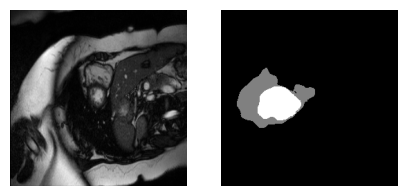

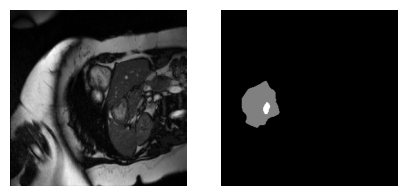

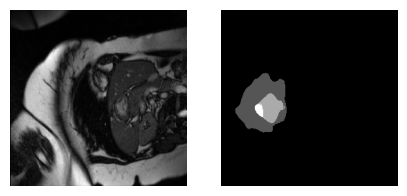

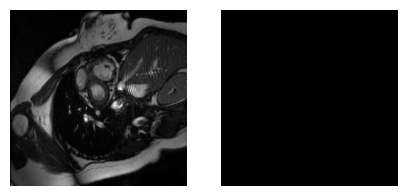

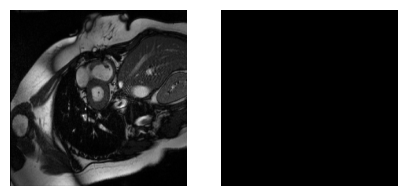

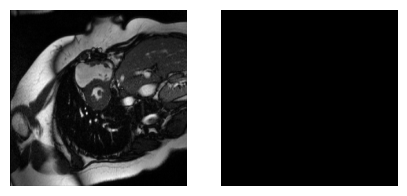

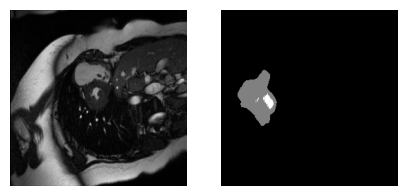

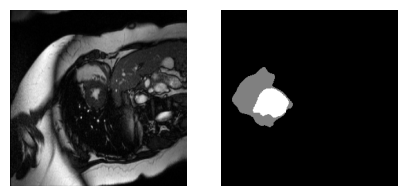

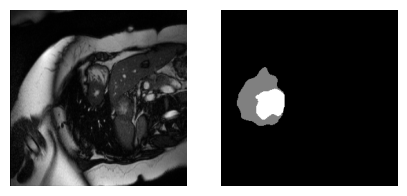

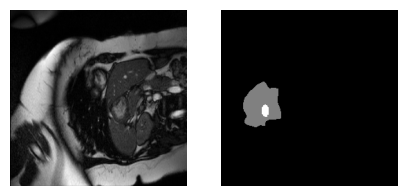

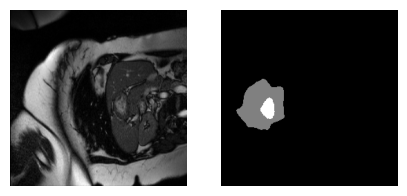

In [9]:
# Load final model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print(f"The current device is {device}")

#model=torch.load('u-effb4_100.pth')
model.to(device)

model.eval()

input_test_data_path = './data/test'
output_test_mask_path='./data/test/mask'
num_workers = 0
batch_size = 1



test_set = TestDataset(input_test_data_path)
test_data_loader = DataLoader(dataset=test_set, num_workers=num_workers,batch_size=batch_size, shuffle=False)

    
for image,img_paths in test_data_loader:
        image = image.to(device)
        out = model(image)
        out_np = torch.max(out,1).indices.cpu().detach().numpy()
        image_np = image.cpu().detach().numpy()
        for i in range(batch_size):
            show_image_mask(image_np[i, 0], out_np[i], cmap='gray')
            image_name = img_paths[i].split('\\')[-1].split('.')[0] + '_mask.png'
            save_path = os.path.join(output_test_mask_path, image_name)
            # Save the composite visualization
            cv2.imwrite(os.path.join(output_test_mask_path,image_name),out_np[0])
            #save_image_mask_side_by_side(image_np[i, 0], out_np[i], save_path, cmap='gray')

In [ ]:
import numpy as np
import os
import cv2

def rle_encoding(x):
    '''
    *** Credit to https://www.kaggle.com/rakhlin/fast-run-length-encoding-python ***
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def submission_converter(mask_directory, path_to_save):
    writer = open(os.path.join(path_to_save, "submission.csv"), 'w')
    writer.write('id,encoding\n')

    files = os.listdir(mask_directory)

    for file in files:
        name = file[:-4]
        mask = cv2.imread(os.path.join(mask_directory, file), cv2.IMREAD_UNCHANGED)

        mask1 = (mask == 1)
        mask2 = (mask == 2)
        mask3 = (mask == 3)

        encoded_mask1 = rle_encoding(mask1)
        encoded_mask1 = ' '.join(str(e) for e in encoded_mask1)
        encoded_mask2 = rle_encoding(mask2)
        encoded_mask2 = ' '.join(str(e) for e in encoded_mask2)
        encoded_mask3 = rle_encoding(mask3)
        encoded_mask3 = ' '.join(str(e) for e in encoded_mask3)

        writer.write(name + '1,' + encoded_mask1 + "\n")
        writer.write(name + '2,' + encoded_mask2 + "\n")
        writer.write(name + '3,' + encoded_mask3 + "\n")

    writer.close()
submission_converter('./data/test/mask','./data/test')